# Preface

The purpose of this kernel is to explain the concept of Regularization via implementation of Ridge, LASSO, and ElasticNet regression models. 

This kernel is broken down into three sections:
1. Data preparation 
2. Modeling 
3. Acknowledgement

The last sections contains useful resources that can clarify certrain concepts for you.

If you find this kernel useful please click **upvote** :)

In [50]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

#invite people for the Kaggle party
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.special import boxcox1p

import warnings
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
# Any results you write to the current directory are saved as output.


# Modeling packages
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

['housingpics', 'house-prices-advanced-regression-techniques']


In [51]:
df_train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")


# 1. Data Preparation

## 1.1 Data Exploration

In [52]:
df_train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
df_test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

In [53]:
# Lets see the shape of the data prior to processing
print ('Shape of Train set: {}'.format(df_train.shape))
print ('Shape of Test set: {}'.format(df_test.shape))

# Id column does not affect the prediction outcome hence can be dropped. However the Id serieses are saved for future modeling
test_id = df_test['Id']
train_id = df_train['Id']

# Dropping Id column
df_test.drop("Id", axis = 1, inplace = True)
df_train.drop("Id", axis = 1, inplace = True)

# Lets see the shape of the data prior to processing
print ('\nShape of Train set after removing Id: {}'.format(df_train.shape))
print ('Shape of Test set after removing Id: {}'.format(df_test.shape))



Shape of Train set: (1460, 81)
Shape of Test set: (1459, 80)

Shape of Train set after removing Id: (1460, 80)
Shape of Test set after removing Id: (1459, 79)


## 1.2 Target Feature Normalization 

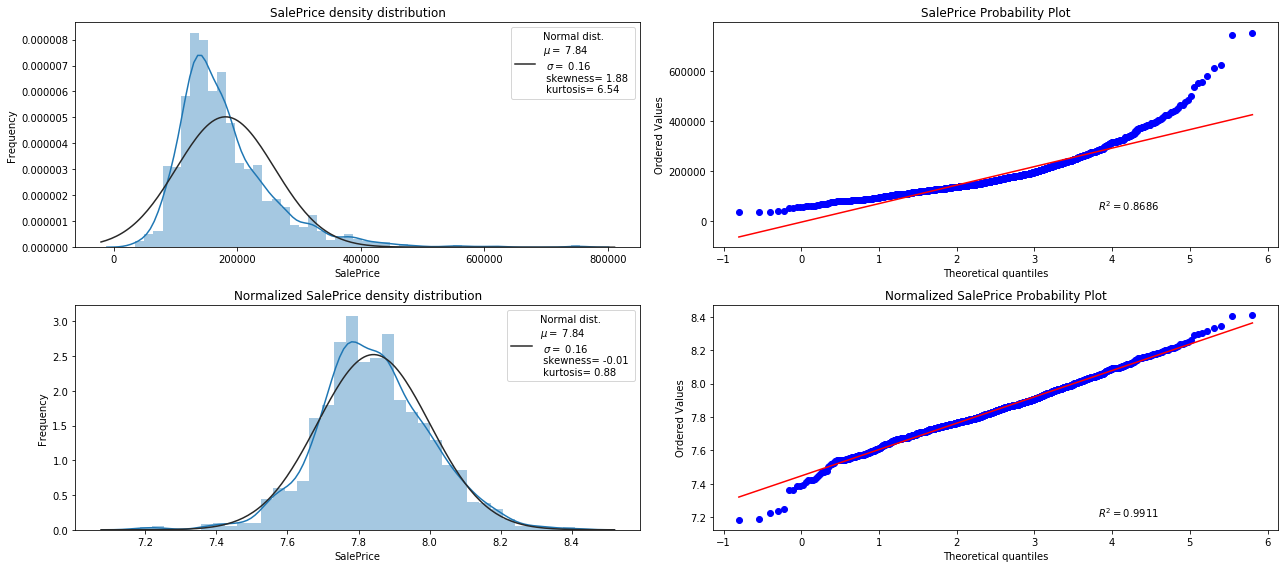

In [54]:
original = df_train['SalePrice']
df_train['SalePrice'] = stats.boxcox(df_train['SalePrice'])[0]

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df_train['SalePrice'])
(mu_norm, sigma_norm) = norm.fit(df_train['SalePrice'])

# Get Skewness and Kurtosis 
original_skew = original.skew()
original_kurt = original.kurt()

transf_skew = df_train['SalePrice'].skew()
transf_kurt = df_train['SalePrice'].kurt()

plt.figure(figsize=(18,8))

#Now plot the distribution
plt.subplot(221)
sns.distplot(original , fit=norm)
plt.legend(['Normal dist. \n$\mu=$ {:.2f} \n $\sigma=$ {:.2f} \n skewness= {:.2f} \n kurtosis= {:.2f}'.format(mu, sigma,original_skew,original_kurt)],loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice density distribution')

#Get also the QQ-plot
plt.subplot(222)
res = stats.probplot(original, sparams=(2.5,), plot=plt, rvalue=True)
plt.title('SalePrice Probability Plot')


#Now plot Normalized distribution
plt.subplot(223)
sns.distplot(df_train['SalePrice'] , fit=norm)
plt.legend(['Normal dist. \n$\mu=$ {:.2f} \n $\sigma=$ {:.2f} \n skewness= {:.2f} \n kurtosis= {:.2f}'.format(mu_norm, sigma_norm,transf_skew,transf_kurt)],loc='best')

plt.ylabel('Frequency')
plt.title('Normalized SalePrice density distribution')

#Get also the QQ-plot for Normalized distribution
plt.subplot(224)
res = stats.probplot(df_train['SalePrice'], sparams=(2.5,), plot=plt, rvalue=True)
plt.title('Normalized SalePrice Probability Plot')
plt.tight_layout()


## 1.2 Removing Outliers

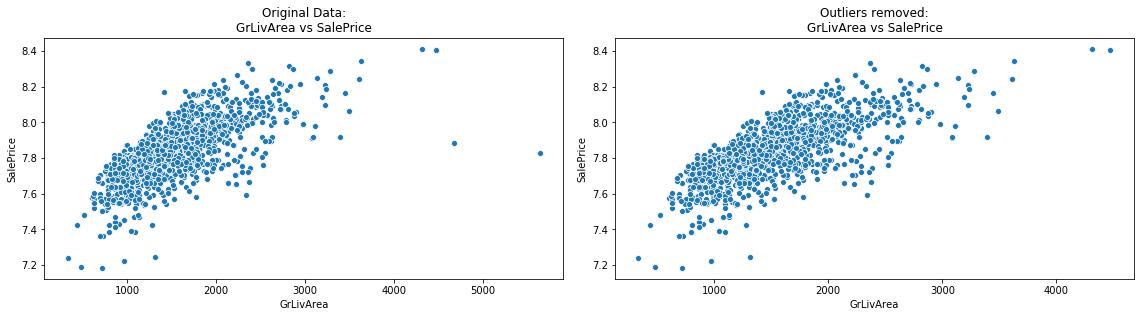

In [55]:
plt.figure(figsize=(16,8))
plt.subplot(221)
sns.scatterplot(x=df_train['GrLivArea'],y=df_train['SalePrice'])
plt.title('Original Data:\nGrLivArea vs SalePrice')

# Removing two outliers with larger living area and low sale price
df_train = df_train.drop(df_train.sort_values(by = 'GrLivArea', ascending = False)[:2].index)

plt.subplot(222)
sns.scatterplot(x=df_train['GrLivArea'],y=df_train['SalePrice'])
plt.title('Outliers removed:\nGrLivArea vs SalePrice')

plt.tight_layout()



## 1.3 Combine Train and Test Data Sets

In [56]:
# Combining Train and Test data sets
all_data = pd.concat((df_train, df_test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)


ntrain = df_train.shape[0] # Will use this to generate a new train data set 
ntest = df_test.shape[0] # Will use this to generate a new test data set
y_train = df_train['SalePrice'].values
y_test = df_train['SalePrice'].values 

## 1.4 Missing Value Imputation

In [57]:
def report_missing_data(df):
    '''
    IN: Dataframe 
    OUT: Dataframe with reported count of missing values, % missing per column and per total data
    '''
    
    missing_count_per_column = df.isnull().sum()
    missing_count_per_column = missing_count_per_column[missing_count_per_column>0]
    total_count_per_column = df.isnull().count()
    total_cells = np.product(df.shape)
    
    # Percent calculation
    percent_per_columnn = 100*missing_count_per_column/total_count_per_column
    percent_of_total = 100*missing_count_per_column/total_cells
    
    # Creating new dataframe for reporting purposes only
    missing_data = pd.concat([missing_count_per_column,
                              percent_per_columnn,
                              percent_of_total], axis=1, keys=['Total_Missing', 'Percent_per_column','Percent_of_total'])
    
    
    missing_data = missing_data.dropna()
    missing_data.index.names = ['Feature']
    missing_data.reset_index(inplace=True)

    
    
    return missing_data.sort_values(by ='Total_Missing',ascending=False)

df = report_missing_data(all_data)


Text(0.5, 1.0, 'Missing Data')

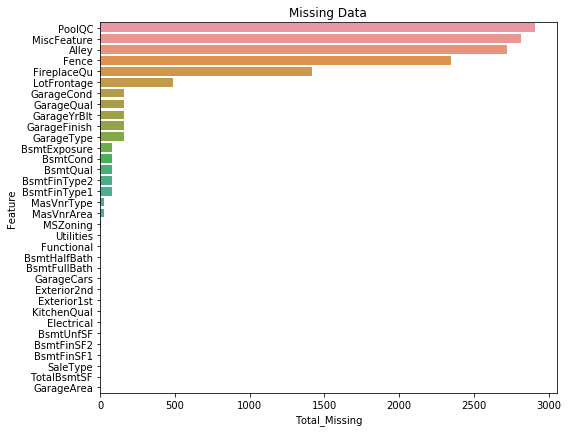

In [58]:
plt.figure(figsize=(18,15))
plt.subplot(221)
sns.barplot(y='Feature',x='Total_Missing',data=df)
plt.title('Missing Data')

This is the time to look at Data Documentation file to choose the proper strategy in dealing with missing values.

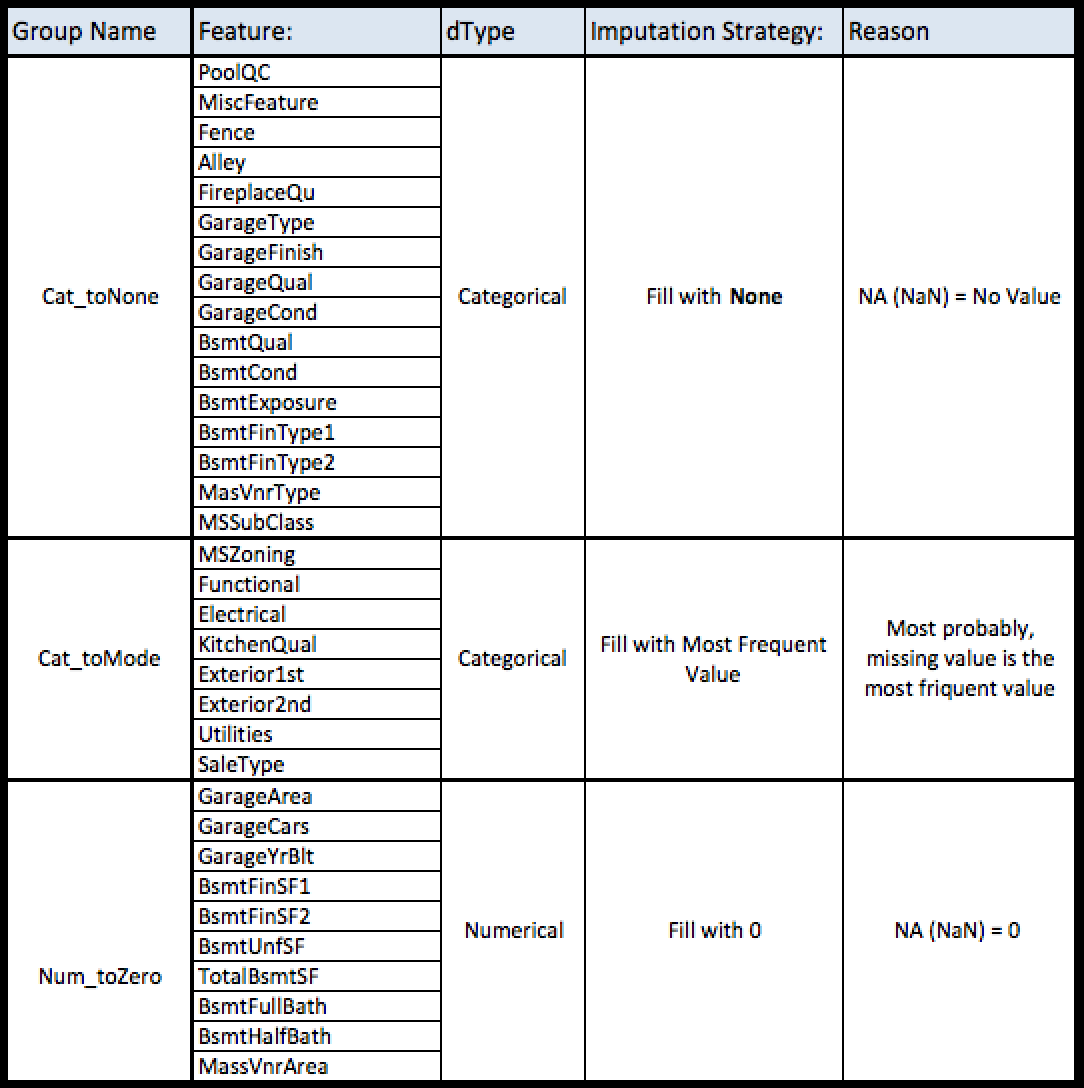

In [59]:
Image("../input/housingpics/missingdata1.png",height=800 , width=600)

In [60]:
# Change Pic Above ( GarageCars 2x)

Cat_toNone = ('PoolQC','Fence','MiscFeature','Alley','FireplaceQu','GarageType','GarageFinish',
              'GarageQual','GarageCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
              'BsmtFinType2','MasVnrType','MSSubClass')
    
Cat_toMode = ('MSZoning','Electrical','KitchenQual','Exterior1st','Exterior2nd',
              'Utilities','SaleType','Functional')

Num_toZero = ('GarageArea','GarageCars','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
              'BsmtFullBath','BsmtHalfBath','GarageYrBlt','MasVnrArea')

for col in Cat_toNone:
    all_data[col]=all_data[col].fillna('None')

for col in Cat_toMode:
    all_data[col]=all_data[col].fillna(all_data[col].mode()[0])
    
for col in Num_toZero:
    all_data[col]=all_data[col].fillna(0)
    


* **LotFrontage** missing data requires deeper analysis. 

Since LotFrontage is the distance of house's front yard, we can make an assumption that it depends on the neighborhood where the house is located. This way we can group LotFrontage values by the neighborhood feature and substitute missing values by the median Lotfrontage distance of the neighborhood. **

In [61]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
report_missing_data(all_data)

,Feature,Total_Missing,Percent_per_column,Percent_of_total


## 1.4 Feature Engineering:

* Total SF - Combining all square footage 

In [62]:
all_data._get_numeric_data()
all_data['Total_SF'] = all_data['1stFlrSF']+all_data['2ndFlrSF']+all_data['TotalBsmtSF']+all_data['GarageArea']+all_data['GrLivArea']+all_data['PoolArea']+all_data['WoodDeckSF']
            

## 1.5 Skewed features transformation

ML regression algorithms love normally distributed data, hence skewed features need to be normalized through transformation. You can think of this process as rescaling and shifting your data. 
We are going to use Box-Cox method with normalization lambda parameter = 0.15.

In [63]:
def bcox_transform(df):
    '''
    IN: Original dataframe 
    OUT: Dataframe with box-cox normalized numerical values. 
    Specified skewness threshold 1 and -1 
    '''
    lam = 0.15
    for feat in df._get_numeric_data():
        if df[feat].skew()>1.0 or df[feat].skew()<-1.0:
            df[feat]=boxcox1p(df[feat], lam)
    return df

all_data = bcox_transform(all_data)

In [64]:
#getting dummie variable
all_data = pd.get_dummies(all_data)

In [65]:
# splitting data back to train and test data sets
df_train = all_data[:ntrain]
df_test = all_data[ntrain:]

 # 2. Modeling


## 2.1 Splitting data into Train and Test sets

In [66]:
X_train = all_data[:df_train.shape[0]]
X_test = all_data[df_train.shape[0]:]
y = y_train

## 2.2 Defining cross-validation

In [67]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

n_folds = 15

# K-fold Root Mean Square Error Cross Validation
def k_rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(df_train.values)
    rmse= np.sqrt(-cross_val_score(model, df_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

Before I jump into explanation, I want you to think of a basic line equation we studied in school.
**y = wx+b**, where **w** - slope of the line and **b** - intercept. 

In machine learning we also deal with line equations, however the dimensionality is no longer 2D, but equal to the number of features(columns) of your data set. To deal with high dimensionality we introduce vector calculus.

*Why using regression in Data Science?*

Regressions allow us to predict output feature values **y** using various linear and nonlinear equations.  

In the typical Ordinary Least Squares (OLS) regression model (Also called Least Square Cost Function), we are **minimizing the sum of square residuals**. In other words, the sum of squared errors between the true (**y**) and estimate (**y hat** or **wX**) values. Important to note that residuals are **local** errors and not systematic.

*Why do we want to improve Ordinary Least Squares regression and introduce Ridge,LASSO, and ElasticNet regressions?*

This is where the Bias-Variance Tradeoff (over and underfitting) phenomena becomes critical to understand. Consider the following definitions and picture below: 

* **Bias** - systematic prediction error. The key word is **systematic** error (in slope **w**) and not local error(residuals of **y**). You can think of Bias as the accuracy of predictions.
* **Variance** - uncertainty or measure of the spread of our weight vector **w** estimates.You can think of Variance as the precisions(consistency) of predictions.

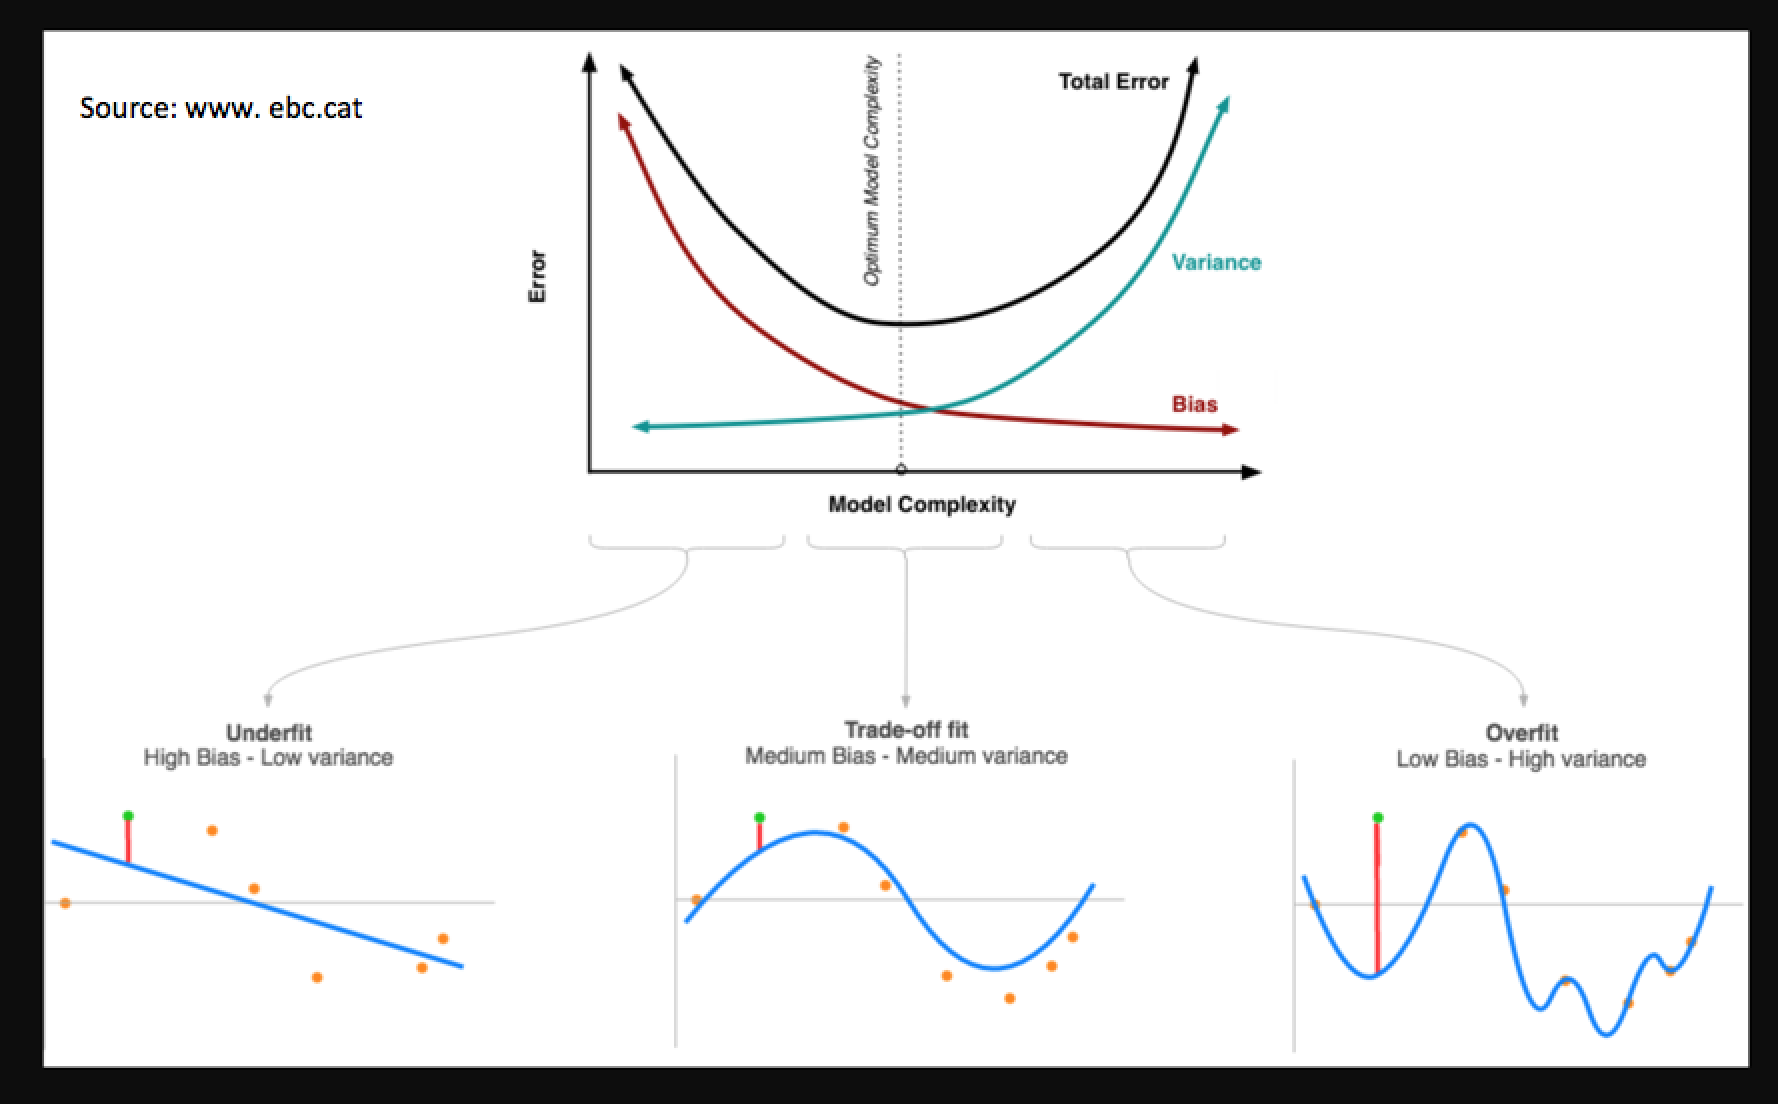

In [68]:
Image("../input/housingpics/bias-variance.png",height=1400 , width=800)

To improve Accuracy (low bias) and Precision (low variance) of our models we introduce Regularization (L1 or L2) terms to our regression equations. Regularization allows us to increase bias and lower the variance of the model by increasing the value of **hyperparameter λ**. Introduction of the initial bias leads to underfitting of the train data set, but optimization of the test data fit. 

* **Ridge Regression:**

**L2 penalized model** where the Square Sum of the weights term is added to Ordinary Least Squares cost function. As hyperparameter **λ** increases Ridge regression introduces more bias into the model, so the training data does not fit well initially, yet overfitting of the test data decreases in the long run. Rigde regression minimizes (penalizes) the effect of irrelevant features as the strength of regularization growth. 

* **LASSO (Least Absolute Shrinkage and Selection Operator)**:

**L1 penalized model** where Sum of Absolute weights term is added to Ordinary Least Squares cost function. Regularization strength also increases with an increase in **λ**, however in the case of LASSO, irrelevant feature weights become zero. It is also common to think of LASSO as feature selection model. 

* **ElasticNet Regression**:

**L2 + L1 penalized model** where both regularization temrs are added to Ordinary Least Squares cost function. This model was introduced to limit sometimes inaccurate feature selection of LASSO, where relevant features are being zeroed. By adding L2 term to the model, the chances of preserving important features increase. Generally in definition of ElasticNet, the ratio of L1/L2 needs to be specified, yet for many applications it is kept at 0.5. 

Now, let's try to use some machine learning notations used in equations below:

* **X** - input variable
* **w** - weight vector. In a simple line equation this was our slope (coefficient to the input X) . We are trying to estimate our weight vector **w** through regression.
* **y** - output feature value. Mathematically it is equal to a dot product of **wX**. We are distinguishing **real y** from **predicted y** by adding hat(triangle) symbol to the **predicted y** (See table figure below).
* **λ** - hyperparameter that determines strengths of Ridge, LASSO, and ElasticNet regression. 


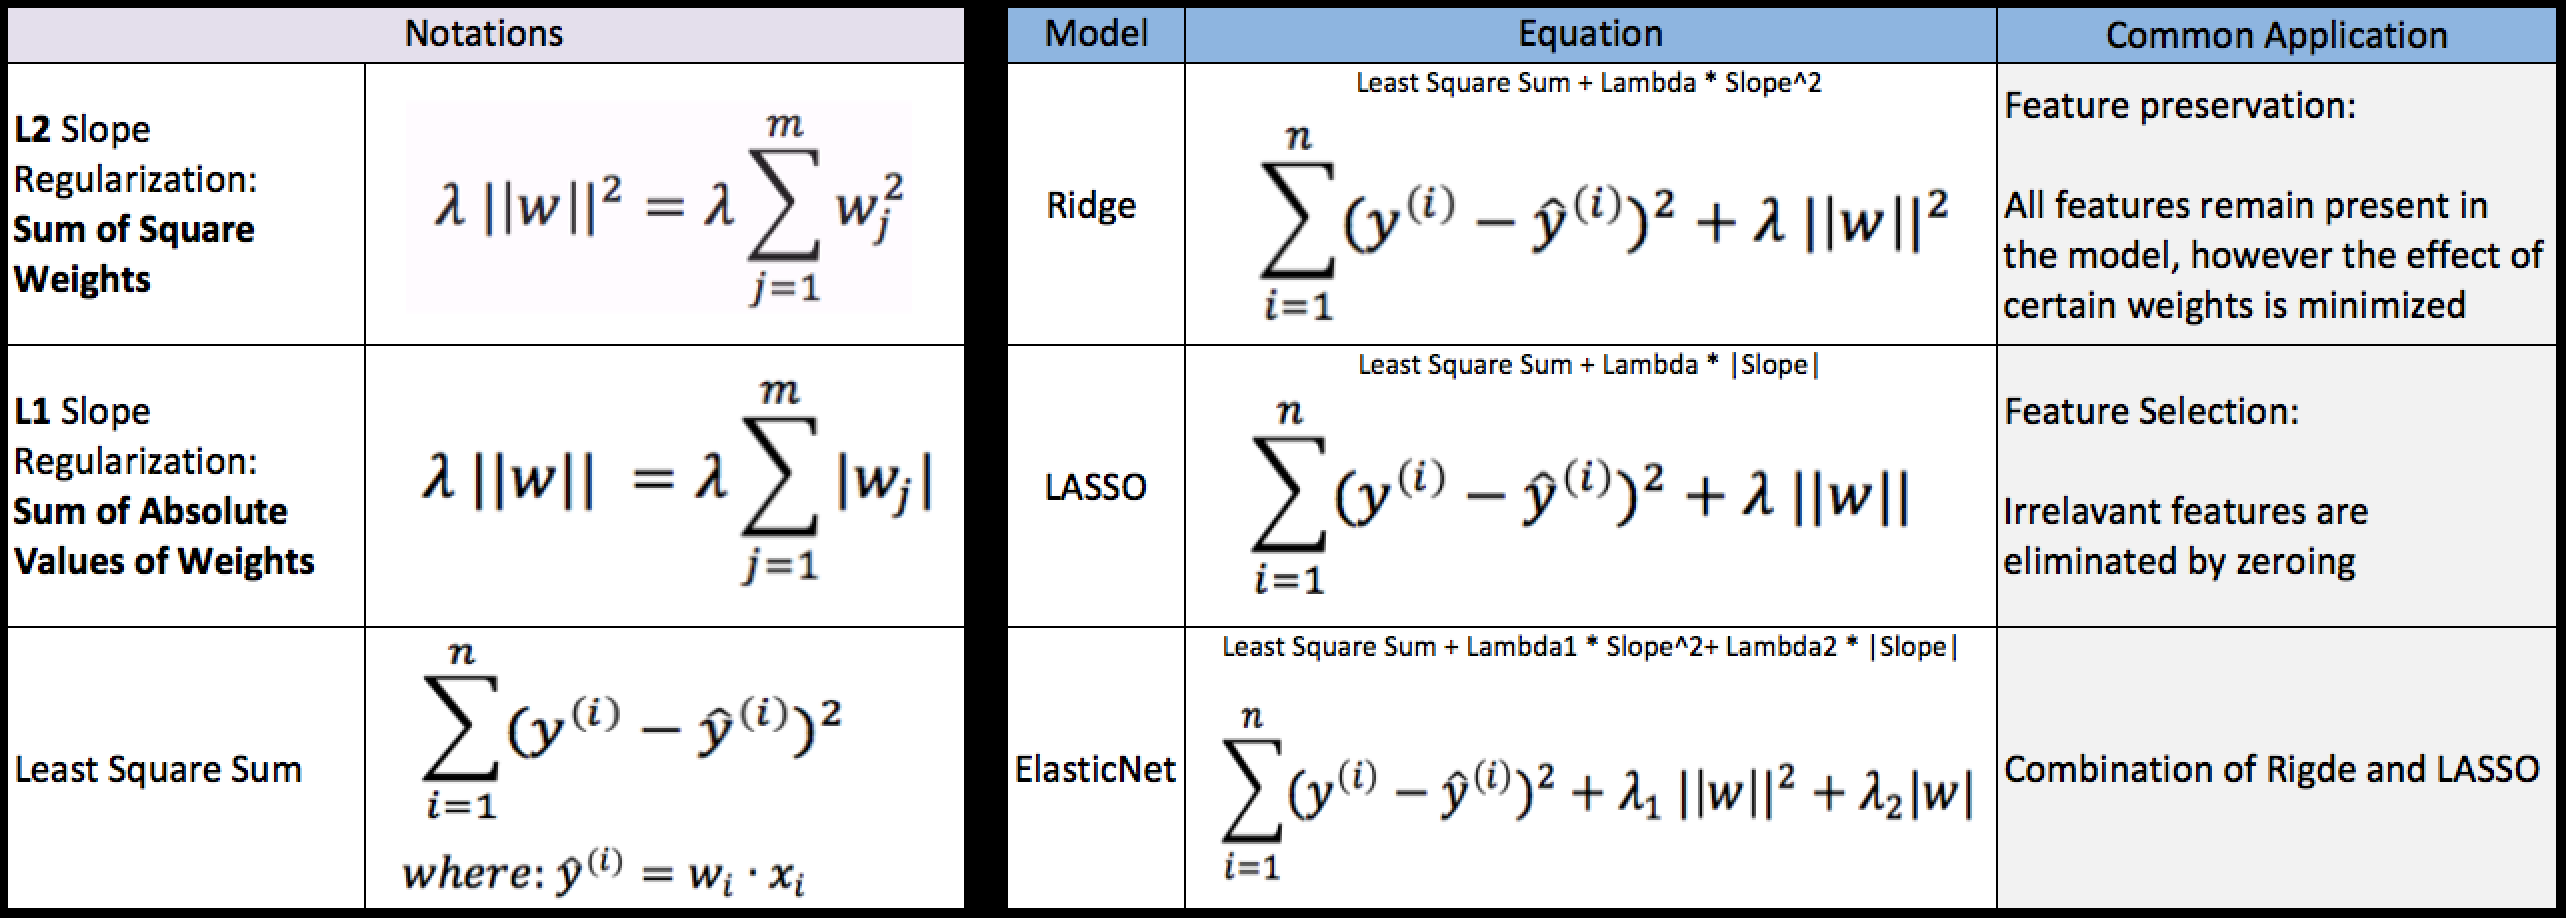

In [69]:
Image("../input/housingpics/regequation.png",height=1600 , width=1000)

## 2.3 Defining models 

In [70]:
# Definning models
model_ridge = Ridge()
model_lasso = Lasso()
model_elasticNet = ElasticNet(l1_ratio=0.5)

# Tunning hyperparameter
# In this example we use alpha as our hyperparameter lambda. 
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]

# Evaluating models through k-fold cross-validation defined earlier
cv_ridge = [k_rmsle_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

cv_lasso = [k_rmsle_cv(Lasso(alpha = alpha)).mean() 
            for alpha in alphas]

cv_elasticNet = [k_rmsle_cv(ElasticNet(alpha = alpha)).mean() 
            for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_elasticNet = pd.Series(cv_elasticNet, index = alphas)

## 2.4 Plotting model Validation Curves

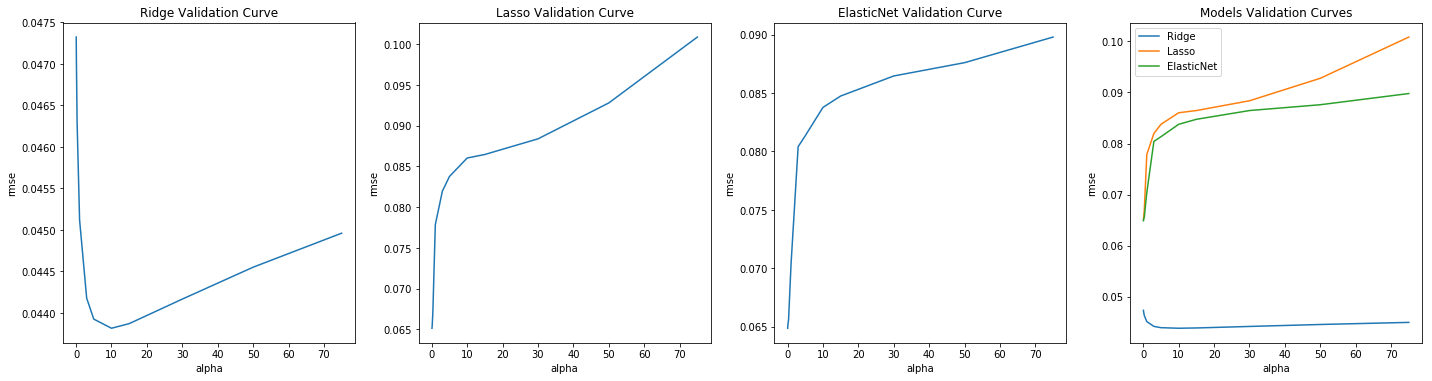

In [71]:
plt.figure(figsize=(20,10))

plt.subplot(241)
cv_ridge.plot(title = "Ridge Validation Curve")
plt.xlabel("alpha")
plt.ylabel("rmse")

cv_lasso = pd.Series(cv_lasso, index = alphas)
plt.subplot(242)
cv_lasso.plot(title = "Lasso Validation Curve")
plt.xlabel("alpha")
plt.ylabel("rmse")

cv_elasticNet = pd.Series(cv_elasticNet, index = alphas)
plt.subplot(243)
cv_elasticNet.plot(title = "ElasticNet Validation Curve")
plt.xlabel("alpha")
plt.ylabel("rmse")

plt.subplot(244)
cv_ridge.plot()
cv_lasso.plot()
cv_elasticNet.plot()
plt.legend(labels=['Ridge','Lasso','ElasticNet'])
plt.title('Models Validation Curves')
plt.xlabel("alpha")
plt.ylabel("rmse")

plt.tight_layout()

### Conclusion
Based on the results of Validation curves, Ridge regression shows the lowest **RMSE value 0.0452** at alpha = 10, which indicates the highest performance out of three models considered. We can make hypothesis that the reason why Ridge regression outperformed LASSO is due to the fact that all features presented in this data set influence the Saleprice and that LASSO regression potentially turns some of them into zeros. The fact that ElasticNet also outperformed LASSO supports this hypothesis.

The main purpose of this kernel is to explain the concept of Regularization as well as Ridge, LASSO, and ElasticNet regressions. 

However, if you like to improve the accuracy, you can try to experiment with the following approaches:
* Feature selection
* Holdout cross validation method
* Grid Search tunning model 
* Other regression algorithms such as: Xgboost, LightGBM, Kernel Ridge, and Stack Regression Method

## If you find this kernel useful please hit that UPVOTE button :) 

### 2.5 Model Result Submission

In [72]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

model_ridge.fit(df_train, y_train)
model_ridge_pred = model_ridge.predict(df_train)
ridge_pred = np.expm1(model_ridge.predict(df_test.values))

In [75]:
submission = pd.DataFrame()
submission['Id'] = test_id
submission['SalePrice'] = ridge_pred
submission.to_csv('../house_pricing_submission.csv',index=False)



# 3. Acknowledgement

Kernels:
* [Bsivavenu's House Price Calculation methods for beginners](https://www.kaggle.com/bsivavenu/house-price-calculation-methods-for-beginners)
* [Serigne's Stacked Regressions : Top 4% on LeaderBoard](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard)

Books:
* Raschka Sebastian, Python Machine Learning, Ch 3,5,6,10

Articles:
* [Regression Analysis: Lasso, Ridge, and Elastic Net](https://towardsdatascience.com/regression-analysis-lasso-ridge-and-elastic-net-9e65dc61d6d3)
* [Regularization: Ridge, Lasso and Elastic Net
](https://www.datacamp.com/community/tutorials/tutorial-ridge-lasso-elastic-net)



Youtube videos:

* [Ridge Regression](https://www.youtube.com/watch?v=Q81RR3yKn30)

* [Lasso Regression](https://www.youtube.com/watch?v=NGf0voTMlcs)